In [3]:
import pandas as pd
import numpy as np
import requests

In [5]:
solar_url = 'https://power.larc.nasa.gov/api/temporal/daily/point?start=20111026&end=20201110&latitude=51.260197&longitude=4.402771&community=re&parameters=T2M%2CALLSKY_SFC_SW_DWN%2CRH2M%2CWS2M%2CPS%2CCLOUD_AMT&format=json&user=Research&header=true&time-standard=lst'

response = requests.get(url=solar_url, verify=True, timeout=30.00)
content = json.loads(response.content.decode('utf-8'))

In [6]:
data = {
    'Solar_Irradiance': content['properties']['parameter']['ALLSKY_SFC_SW_DWN'],
    'Temperature_2m': content['properties']['parameter']['T2M'],
    'Relative_Humidity_2m': content['properties']['parameter']['RH2M'],
    'Wind_Speed_2M': content['properties']['parameter']['WS2M'],
    'Surface_Pressure': content['properties']['parameter']['PS'],
    'Cloud_Amount': content['properties']['parameter']['CLOUD_AMT']
}

In [7]:
solarDF = pd.DataFrame(data)
solarDF.index = pd.to_datetime(solarDF.index, format='%Y%m%d')

In [11]:
solarDF.tail()

,Solar_Irradiance,Temperature_2m,Relative_Humidity_2m,Wind_Speed_2M,Surface_Pressure,Cloud_Amount
2020-11-06,1.89,6.35,79.26,2.41,103.08,24.79
2020-11-07,1.71,7.75,92.54,2.00,102.21,10.38
2020-11-08,1.08,9.58,95.38,1.74,102.03,71.08
2020-11-09,1.37,10.96,92.58,1.63,102.13,66.58
2020-11-10,1.34,10.98,94.36,1.28,102.39,76.15


In [62]:
print(solarDF.columns)

Index(['date', 'date', 'date', 'Solar_Irradiance', 'Temperature_2m',
       'Relative_Humidity_2m', 'Wind_Speed_2M', 'Surface_Pressure',
       'Cloud_Amount'],
      dtype='object')


In [11]:
output_DF = pd.read_csv("PV_Elec_Gas3.csv")
output_DF_filtered = output_DF[['date', 'Cumulative_solar_power']]

In [13]:
output_DF_filtered.head()

,date,Cumulative_solar_power
0,26/10/2011,0.1
1,27/10/2011,10.2
2,28/10/2011,20.2
3,29/10/2011,29.6
4,30/10/2011,34.2


In [15]:
output_DF_filtered['date'] = pd.to_datetime(output_DF_filtered['date'], format='%d/%m/%Y')

C:\Users\simon\AppData\Local\Temp\ipykernel_29720\259644958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_DF_filtered['date'] = pd.to_datetime(output_DF_filtered['date'], format='%d/%m/%Y')


In [17]:
output_DF_filtered['Daily_solar_power'] = output_DF_filtered['Cumulative_solar_power'].diff()

C:\Users\simon\AppData\Local\Temp\ipykernel_29720\2211926935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_DF_filtered['Daily_solar_power'] = output_DF_filtered['Cumulative_solar_power'].diff()


In [19]:
output_DF_filtered.head()

,date,Cumulative_solar_power,Daily_solar_power
0,2011-10-26,0.1,NaN
1,2011-10-27,10.2,10.1
2,2011-10-28,20.2,10.0
3,2011-10-29,29.6,9.4
4,2011-10-30,34.2,4.6


In [21]:
output_DF_filtered['Daily_solar_power'] = output_DF_filtered['Daily_solar_power'].fillna(0.1)

C:\Users\simon\AppData\Local\Temp\ipykernel_29720\2291712674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_DF_filtered['Daily_solar_power'] = output_DF_filtered['Daily_solar_power'].fillna(0.1)


In [23]:
output_DF_filtered = output_DF_filtered.drop(columns = ['Cumulative_solar_power'])

In [25]:
solarDF = solarDF.reset_index()
solarDF.rename(columns={'index': 'date'}, inplace=True)

solarDF['date'] = pd.to_datetime(solarDF['date'], format='%Y-%m-%d')

In [27]:
merged_df = pd.merge(output_DF_filtered, solarDF, on='date', how='inner')

In [29]:
merged_df.head()

,date,Daily_solar_power,Solar_Irradiance,Temperature_2m,Relative_Humidity_2m,Wind_Speed_2M,Surface_Pressure,Cloud_Amount
0,2011-10-26,0.1,1.98,9.46,87.73,4.13,100.93,49.97
1,2011-10-27,10.1,1.94,9.83,80.80,3.68,101.21,94.26
2,2011-10-28,10.0,1.97,12.29,88.43,1.38,102.09,58.30
3,2011-10-29,9.4,1.10,12.71,89.61,2.48,102.15,73.87
4,2011-10-30,4.6,1.21,12.42,92.93,2.98,102.01,61.33


In [41]:
import matplotlib.pyplot as plt

In [43]:
import seaborn as sns

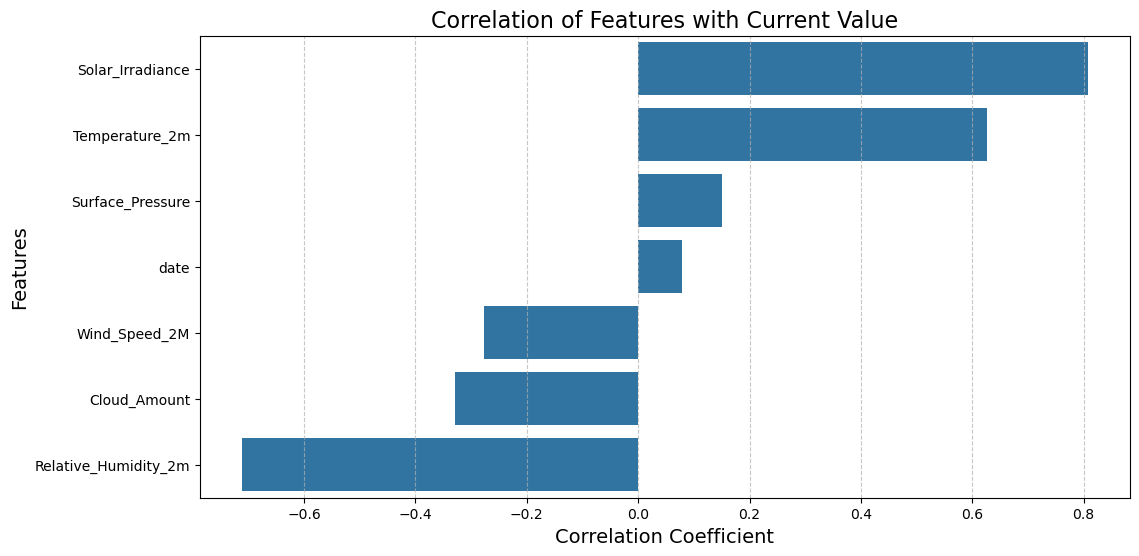

In [45]:
correlations = merged_df.corr()['Daily_solar_power'].sort_values(ascending=False)

correlations = correlations.drop('Daily_solar_power')

plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.values, y=correlations.index)

plt.title('Correlation of Features with Current Value', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.ylabel('Features', fontsize=14)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show() 

In [47]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [51]:
x = merged_df[['Solar_Irradiance', 'Temperature_2m', 'Relative_Humidity_2m', 'Wind_Speed_2M', 'Surface_Pressure', 'Cloud_Amount']]
y = merged_df['Daily_solar_power']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [53]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

gbr.fit(x_train, y_train)

GradientBoostingRegressor(random_state=42)

In [55]:
y_pred = gbr.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [57]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 3.4051939820864283
Mean Squared Error (MSE): 20.12847459926347
R² Score: 0.6912369279642145
